# Word embeddings - Word2Vec

### Author: Cecília Assis
#### Github: https://github.com/ceciliassis
#### Linkedin: https://www.linkedin.com/in/ceciliassis/

In [1]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
HEADERS = {
    'User-Agent': (
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36'
        '(KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
    )
}

urls = [
    'https://take.net/blog/4devs/nlp-processamento-linguagem-natural/',
    'https://take.net/blog/4devs/nlp-chatbot/',
    'https://take.net/blog/4devs/cursos-para-aprender-sobre-chatbots/',
    'https://take.net/blog/inovacao/motivos-usar-inteligencia-artificial/',
    'https://take.net/blog/chatbots/algoritmos-inteligencia-artificial-crime/',
    'https://take.net/blog/chatbots/inteligencia-artificial-no-blip/',
    'https://take.net/blog/devs/trabalhar-com-inteligencia-artificial/',
    'https://take.net/blog/inovacao/sucesso-do-cliente-e-inteligencia-artificial/',
    'https://take.net/blog/take-test/testes-em-chatbots-com-nlp/',
    'https://take.net/blog/chatbots/chatbot/',
    'https://take.net/blog/inovacao/big-data/',
    'https://take.net/blog/inovacao/big-data-no-trabalho/',
    'https://take.net/blog/inovacao/transformacao-digital/'
]

In [3]:
# Define stric set of punctuations due to pre processing and Portuguese characteristics (ex. trata-se)
PUNCTUATIONS = ['*', '+', '.', '/', '[', ']', '(', ')', ';', ':', '%', 'º',
                '=', '!', '"','“', "'", "”", "#", '{', '}', ',', '\?']
PUNCTUATIONS_STR = ''.join(PUNCTUATIONS)

In [4]:
import spacy

# Load spacy lang
try:
    spacy.load('pt', disable=['ner'])
except OSError:
    !python -m spacy download pt
finally:
    PT_LANG = spacy.load('pt', disable=['ner'])

In [5]:
# Validade is a word is also a stopword
def is_stopword(word):
    return word in NLTK_STOPWORDS_TABLE

In [6]:
import nltk

# Add nltk stopwords to spacy
try:
    nltk.corpus.stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')
finally:
    nltk_stopwords = nltk.corpus.stopwords.words('portuguese')
    
NLTK_STOPWORDS_TABLE = dict.fromkeys(i for i in nltk_stopwords)

stopwords_extension = ['desse', 'dessa', 'disso', 'dessas', 'desses', 
                       'esse', 'essa', 'nisso', 'nessa', 'nesse', 'deste', 'desta']

# Avoid akward spacy word break
for stopword in stopwords_extension:
    if not is_stopword(stopword):
        NLTK_STOPWORDS_TABLE[stopword] = None

In [7]:
import textacy.preprocessing
import ftfy

from readability import Document
from bs4 import BeautifulSoup

import requests

class Article():
    def __init__(self, url):
        self.url = url
        
    @property
    def html(self):
        if not hasattr(self, '_html'):
            self._html = self.get_html()
    
        return self._html
    
    
    @property
    def soup(self):
        if not hasattr(self, '_soup'):
            self._soup = self.get_soup()
    
        return self._soup
    
    @property
    def text(self):
        if not hasattr(self, '_text'):
            self._text = self.get_text()
    
        return self._text
    
    @property
    def spacy_doc(self):
        if not hasattr(self, '_spacy_doc'):
            self._spacy_doc = self.get_spacy_doc()
    
        return self._spacy_doc
    
    def get_html(self):
        article = requests.get(self.url, headers=HEADERS)
        
        return article.content
    
    
    def get_soup(self):
        soup = BeautifulSoup(self.html, 'html.parser')
        tags_to_remove = ['script', 'style', 'noscript', 
                          'aside', 'footer', 'header', 'div.newsletter']

        for tag in soup(tags_to_remove):
            tag.decompose()
            
        for tag in soup.find_all(class_='newsletter'):
            tag.decompose()
            
        document = Document(soup.encode(formatter="html5"))
        soup = BeautifulSoup(document.summary(), 'html.parser')
        
        return soup
        
        
    def get_text(self):
        text = self.soup.get_text("")
        text = text.lower()
        
        text = ftfy.fix_text(text)
        text = textacy.preprocessing.remove_punctuation(text, marks=PUNCTUATIONS_STR)
        text = textacy.preprocessing.replace_numbers(text, replace_with=' ')
        text = textacy.preprocessing.normalize_whitespace(text)

        text = text.split()
        text = ' '.join(word for word in text if not is_stopword(word))
        
        return text
    
    
    def get_spacy_doc(self):
        return textacy.make_spacy_doc(self.text, lang=PT_LANG)
    

#     ------------
    
def read_pages(urls):
    return [Article(url) for url in urls]

----

## Build corpora
Build corpora from posts

In [8]:
def build_corpus(pages, kwargs):
    return [
        list(page.spacy_doc._.to_terms_list(**kwargs))
        for page in pages
    ]

In [9]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

pages = read_pages(urls)

kwargs = {'as_strings':True, 'normalize': None, 'ngrams':(1)}

corpus = build_corpus(pages, kwargs)
assert len(corpus) == len(pages)

INFO - 20:55:43: ruthless removal did not work. 
INFO - 20:55:43: Top 5 : 424.523 .entry-content-wrap>.entry-content
INFO - 20:55:43: Top 5 : 226.586 .entry-container>.entry-content-wrap
INFO - 20:55:43: Top 5 : 36.100 .post-inner>.entry-details
INFO - 20:55:43: Top 5 : 35.100 .post-inner>.entry-details
INFO - 20:55:43: Top 5 : 34.300 .post-inner>.entry-details
INFO - 20:55:48: ruthless removal did not work. 
INFO - 20:55:48: Top 5 : 102.768 .entry-content-wrap>.entry-content
INFO - 20:55:48: Top 5 : 65.152 .entry-container>.entry-content-wrap
INFO - 20:55:48: Top 5 : 36.100 .post-inner>.entry-details
INFO - 20:55:48: Top 5 : 35.100 .post-inner>.entry-details
INFO - 20:55:48: Top 5 : 34.300 .post-inner>.entry-details
INFO - 20:55:51: ruthless removal did not work. 
INFO - 20:55:51: Top 5 : 123.783 .entry-content-wrap>.entry-content
INFO - 20:55:51: Top 5 : 75.630 .entry-container>.entry-content-wrap
INFO - 20:55:51: Top 5 : 36.100 .post-inner>.entry-details
INFO - 20:55:51: Top 5 : 35.

## Retrieve unigrams and bigrams from vocab
After building the corpora, the senteces are passed to gensim's Phrases model that detects common phrases and its ngrams.

In [10]:
phrases = Phrases(corpus)
sentences = phrases[corpus]

INFO - 20:56:11: collecting all words and their counts
INFO - 20:56:11: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:56:11: collected 9172 word types from a corpus of 7235 words (unigram + bigrams) and 13 sentences
INFO - 20:56:11: using 9172 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


## Build model vocab
Buuild the model vocabulary based on the sentences previously created.

In [11]:
# Build model vocab
from time import time

w2v_model = Word2Vec()

t = time()
w2v_model.build_vocab(sentences)
print(f'Time to build vocab: {round((time() - t) / 60, 2)} mins')

print(f'Vocabulary size: {len(w2v_model.wv.vocab)} word')

INFO - 20:56:11: collecting all words and their counts
INFO - 20:56:11: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:56:11: collected 2661 word types from a corpus of 7017 raw words and 13 sentences
INFO - 20:56:11: Loading a fresh vocabulary
INFO - 20:56:11: effective_min_count=5 retains 331 unique words (12% of original 2661, drops 2330)
INFO - 20:56:11: effective_min_count=5 leaves 3578 word corpus (50% of original 7017, drops 3439)
INFO - 20:56:11: deleting the raw counts dictionary of 2661 items
INFO - 20:56:11: sample=0.001 downsamples 123 most-common words
INFO - 20:56:11: downsampling leaves estimated 2719 word corpus (76.0% of prior 3578)
INFO - 20:56:11: estimated required memory for 331 words and 100 dimensions: 430300 bytes
INFO - 20:56:11: resetting layer weights


Time to build vocab: 0.0 mins
Vocabulary size: 331 word


## Train model
Train the Word2Vec model, using the following parameters:

- `size`: 100 (dimensionality of the word vectors)
- `alpha`: 0.025 (initial learning rate)
- `window`: 5 (maximum distance between the current and predicted word within a sentence)
- `seed`: 1 (random generator seed for reproducibility)
- `min_alpha`: 0.0001 (learning rate lower bound)
- `min_count`: 5 (word frequency lower bound)
- `negative`: 5 (if > 0, sets how many “noise words” should be drawn (usually between 5-20))
- `epochs`: 30 (number of epochs, i.e. iterations, over the corpus)
- `report_delay`: 1 (seconds to wait before reporting progress)
- `total_examples`: 13 (corpus length)

In [12]:
# Train model
t = time()

w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, 
                report_delay=1,
                seed=1
               )

print(f'Time to train the model: {round((time() - t) / 60, 2)} mins')

INFO - 20:56:11: training model with 3 workers on 331 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 20:56:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:56:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:56:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:56:12: EPOCH - 1 : training on 7017 raw words (2669 effective words) took 0.1s, 42811 effective words/s
INFO - 20:56:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:56:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:56:12: worker thread finished; awaiting finish of 0 more threads
INFO - 20:56:12: EPOCH - 2 : training on 7017 raw words (2744 effective words) took 0.0s, 65635 effective words/s
INFO - 20:56:12: worker thread finished; awaiting finish of 2 more threads
INFO - 20:56:12: worker thread finished; awaiting finish of 1 more threads
INFO - 20:56:12: worker thread finished;

INFO - 20:56:13: worker thread finished; awaiting finish of 2 more threads
INFO - 20:56:13: worker thread finished; awaiting finish of 1 more threads
INFO - 20:56:13: worker thread finished; awaiting finish of 0 more threads
INFO - 20:56:13: EPOCH - 25 : training on 7017 raw words (2700 effective words) took 0.0s, 55157 effective words/s
INFO - 20:56:13: worker thread finished; awaiting finish of 2 more threads
INFO - 20:56:13: worker thread finished; awaiting finish of 1 more threads
INFO - 20:56:13: worker thread finished; awaiting finish of 0 more threads
INFO - 20:56:13: EPOCH - 26 : training on 7017 raw words (2721 effective words) took 0.0s, 63541 effective words/s
INFO - 20:56:13: worker thread finished; awaiting finish of 2 more threads
INFO - 20:56:13: worker thread finished; awaiting finish of 1 more threads
INFO - 20:56:13: worker thread finished; awaiting finish of 0 more threads
INFO - 20:56:13: EPOCH - 27 : training on 7017 raw words (2712 effective words) took 0.0s, 5430

Time to train the model: 0.03 mins


In [13]:
# Pre compute L2-normalized vector
# After this call, no more training can be done

w2v_model.wv.init_sims(replace=True)

INFO - 20:56:13: precomputing L2-norms of word weight vectors


## Vector representation
Since Word2Vec model assignsa vector representation to each word, below are some of them.

In [14]:
w2v_model.wv.vocab.keys()

dict_keys(['nlp', 'natural', 'processamento_linguagem', 'português', 'tecnologia', 'usada', 'ajudar', 'linguagem', 'humano', 'maneira', 'responder', 'demandas', 'processo', 'simples', 'aplicativos', 'realizar', 'pesquisa', 'google', 'receber', 'resposta', 'qualidade', 'usam', 'linguagens', 'diferentes', 'preciso', 'permitir', 'compreensão', 'máquina', 'melhor', 'experiência', 'usuário', 'conversa', 'texto', 'inteligência_artificial', 'ia', 'desenvolver', 'capacidade', 'entender', 'seres_humanos', 'diferença', 'linguagem_natural', 'programação', 'humanos', 'pessoas', 'máquinas', 'comuns', 'podemos', 'criar', 'sistemas', 'aplicações', 'permite', 'entenda', 'usando', 'respostas', 'interações', 'exemplos', 'aplicação', 'chatbot', 'empresa', 'capaz', 'informações', 'contato', 'usuários', 'estrutura', 'complexos', 'sendo', 'possa', 'humana', 'conceitos', 'processamento', 'machine_learning', 'deep', 'learning', 'ml', 'aprendizado_máquina', 'assunto', 'redes', 'neurais', 'melhorar', 'fala', 'l

In [15]:
def print_w2v(w2v_model, word):
    print(f'Vector of word "{word}"')
    print(w2v_model.wv.word_vec(word))

In [16]:
print_w2v(w2v_model, 'nlp')
print_w2v(w2v_model, 'machine_learning')

Vector of word "nlp"
[-4.46643196e-02 -1.09633461e-01 -2.21896488e-02 -9.64248106e-02
 -1.11318499e-01  2.25752462e-02  1.86046466e-01 -1.11247309e-01
  3.69046703e-02  1.40680939e-01  2.13314649e-02  1.66864142e-01
  1.99270342e-02 -2.09728688e-01 -2.17698142e-02  9.94488150e-02
  1.16095943e-02  1.44769311e-01 -8.65971446e-02 -1.13751188e-01
  6.75724745e-02  7.90500734e-03  1.16465390e-02  1.50430501e-01
  6.93926066e-02 -2.16823649e-02  2.67310739e-02  8.26434270e-02
 -6.85559884e-02  1.15670897e-01 -4.27743560e-03 -1.25000820e-01
 -5.09605259e-02 -1.03956319e-01 -5.97085617e-02  7.04443157e-02
  5.79724759e-02 -8.07820633e-02  3.73213589e-02  1.07771166e-01
 -6.02813363e-02 -5.22259660e-02  1.96655765e-02 -4.80332441e-04
  2.12737709e-01 -6.73724338e-02  5.81009127e-02  7.15658739e-02
  6.70396164e-02  9.83492732e-02 -1.13999724e-01  1.56138907e-03
 -2.01230034e-01  1.03129961e-01 -3.53823826e-02 -3.19257937e-02
 -1.93158925e-01  8.92082676e-02 -4.38630348e-03 -1.39225721e-01
  1.

## Most similar
Word embeddings enables us to find similarities along the vector space through calculations such as cosine one. Below we have top 10 similar word for 3 words present in the vocabulary.

In [17]:
def top_10_similar(w2v_model, word):
    words = w2v_model.wv.most_similar(positive=[word])
    words = [w[0] for w in words]
    print(f'Top 10 similar words for {word}: {words}')

In [31]:
top_10_similar(w2v_model, 'aprender')
top_10_similar(w2v_model, 'machine_learning')
top_10_similar(w2v_model, 'inteligência_artificial')
top_10_similar(w2v_model, 'nlp')

Top 10 similar words for aprender: ['assunto', 'algoritmos', 'humano', 'valores', 'ia', 'uso', 'importante', 'negócios', 'desenvolvimento', 'difícil']
Top 10 similar words for machine_learning: ['algoritmos', 'permite', 'aprendizado_máquina', 'fala', 'inteligência_artificial', 'nlp', 'linguagens', 'ia', 'conceitos', 'usuário']
Top 10 similar words for inteligência_artificial: ['compreender', 'ia', 'sendo', 'fala', 'precisa', 'sistemas', 'conjunto', 'usuário', 'interação', 'nlp']
Top 10 similar words for nlp: ['entenda', 'diálogo', 'sistemas', 'inteligência_artificial', 'palavras', 'aprender', 'principais', 'compreensão', 'usuário', 'usuários']


## Analogy difference
Vector representations also enables us to sum and/or subtract words from other, leading to highly informative concepts as shown below.

In [19]:
def vector_association(w2v_model, positive_words, negative_word):
    words = w2v_model.wv.most_similar(positive=positive_words, 
                                      negative=[negative_word],
                                      topn=1)
    words = [w[0] for w in words]
    print(f'Which word is to "{positive_words[0]}" as "{positive_words[1]}" is to "{negative_word}"? {words}')

In [34]:
vector_association(w2v_model, ['chatbots', 'machine_learning'], 
                   'nlp')

vector_association(w2v_model, ['usuário', 'nlp'], 
                   'inteligência_artificial')

Which word is to "chatbots" as "machine_learning" is to "nlp"? ['sucesso']
Which word is to "usuário" as "nlp" is to "inteligência_artificial"? ['resposta']


## Odd-One-Out
If we want to know the word that deviates the most from a list of terms, we can ask for the most odd one

In [21]:
def odd_one_out(w2v_model, words):
    word = w2v_model.wv.doesnt_match(words)
    print(f"Which word doesn't fit in the list: {words}? {word}")

In [22]:
odd_one_out(w2v_model, ['nlp', 'inteligência_artificial', 'evento'])

Which word doesn't fit in the list: ['nlp', 'inteligência_artificial', 'evento']? evento


/home/ceciliassis/pessoal/machine-learning/natural-language-processing/word2vec/venv/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


## t-SNE visualization
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a technique for dimensionality reductition. Since humans are more confortable with spaces up to 3 dimensions, this kind of method helps to see how data fit on the explored vector space. 

For more info, see [Visualising high-dimensional datasets using PCA and t-SNE in Python](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b) and [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print(f'Current word embedding dimension: {w2v_model.wv.get_vector("nlp").shape}')

Current word embedding dimension: (100,)


In [24]:
def tsne_representation(w2v_model, word):
    w2v_labels = [word]
    w2v_colors = ['red']
    w2v_arrays = np.empty((0,100), dtype='f')

    w2v = w2v_model.wv.word_vec("nlp")
    w2v_arrays = np.append(w2v_arrays, [w2v], axis=0) 

    # Add similar words to w2v array
    most_similar = w2v_model.wv.most_similar([word])
    w2v_colors.extend(['black'] * len(most_similar))
    for word_score in most_similar:
        w2v_labels.append(word_score[0])
        w2v = w2v_model.wv.word_vec(word_score[0])
        w2v_arrays = np.append(w2v_arrays, [w2v], axis=0)
    
    # reduce w2v dims
    t = time()
    pca = PCA(n_components=5).fit_transform(w2v_arrays)
    print(f'Time to train PCA: {round((time() - t) / 60, 2)} mins')
    
    t = time()
    tsne = TSNE(n_components=2, random_state=0).fit_transform(pca)    
    print(f'Time to train TSNE: {round((time() - t) / 60, 2)} mins')
    
    tsne_dataframe = pd.DataFrame({'x': [x for x in tsne[:, 0]],
                                   'y': [y for y in tsne[:, 1]],
                                   'word': w2v_labels,
                                   'color': w2v_colors})
    
    # Define plot
    fig = plt.figure(figsize=(10, 10))
    
    plot = sns.regplot(data=tsne_dataframe,
                       x='x', 
                       y='y',
                       fit_reg=False, 
                       marker='o', 
                       scatter_kws={
                        's': 40, 
                           'facecolors': tsne_dataframe['color']
                       })
    
    
    # Set annotations
    for line in range(0, tsne_dataframe.shape[0]):
        plt.text(tsne_dataframe['x'][line], 
                tsne_dataframe['y'][line], 
                ' ' + tsne_dataframe['word'][line],
                horizontalalignment='left',
                verticalalignment='bottom', 
                size='medium',
                color=tsne_dataframe['color'][line],
                weight='normal'
               ).set_size(15)
        
    plt.title(f't-SNE visualization for {word}')

Time to train PCA: 0.0 mins
Time to train TSNE: 1.5 mins


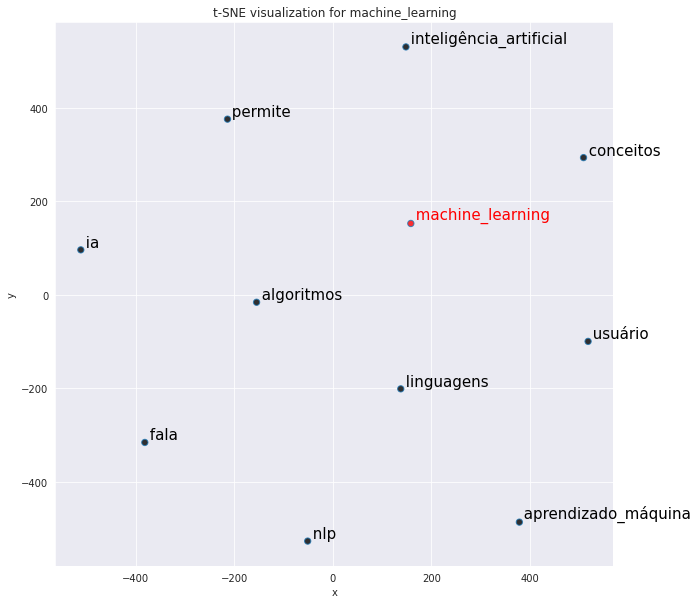

In [25]:
tsne_representation(w2v_model, 'machine_learning')

Time to train PCA: 0.0 mins
Time to train TSNE: 1.38 mins


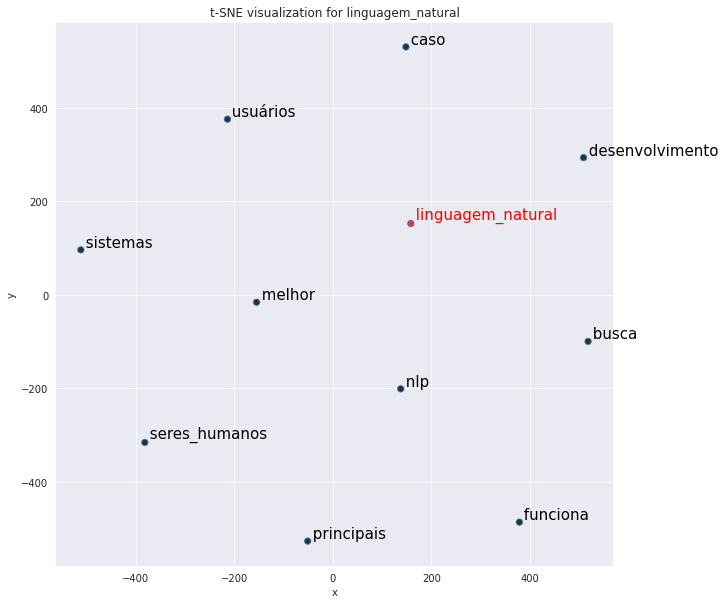

In [26]:
tsne_representation(w2v_model, 'linguagem_natural')

## Summary
Word embeddings allows us to match words against their context, enabling important discoveries.

The results show that through the recovered blog posts, the term "linguagem_natural" (natural language) is associated with words like "seres_humanos" (human being), "desenvolvimento" (developement) and "busca" (search) which, when analyzed contextually, demonstrate the scenario that NLP has been inserted into. Another important result comes from the analogies between vocabulary terms, showing that users today are looking for answers and that sucess is chatbots as machine learning is to nlp.

Finally, the term "machine_learning" was correctly associated with "aprendizado_máquina" (machine_learning), "nlp", "inteligência_artificial" (artificial inteligence) and "algoritmos" (algorithms), words that are very close to what "machine_learning" actually represents.

### Thanks to:
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial